<a href="https://colab.research.google.com/github/martin-fabbri/colab-notebooks/blob/master/linear_classifiers/linear_classifiers_01.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Linear Classifier

In [2]:
!git clone https://github.com/martin-fabbri/colab-notebooks.git

Cloning into 'colab-notebooks'...
remote: Enumerating objects: 29, done.
remote: Counting objects: 100% (29/29), done.
remote: Compressing objects: 100% (26/26), done.
remote: Total 881 (delta 10), reused 16 (delta 3), pack-reused 852
Receiving objects: 100% (881/881), 122.56 MiB | 10.33 MiB/s, done.
Resolving deltas: 100% (460/460), done.
Checking out files: 100% (165/165), done.


In [3]:
import os
os.chdir('colab-notebooks/')
!pwd

/content/colab-notebooks


In [4]:
!pip install alibi

     |████████████████████████████████| 92kB 2.5MB/s 


In [20]:
import nltk
import en_core_web_sm
import re
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import spacy
import string
import mlxtend

from alibi.explainers import AnchorText
from alibi.datasets import fetch_movie_sentiment
from alibi.utils.download import spacy_model
from mlxtend.plotting import plot_decision_regions
# from nltk.corpus import stopwords
from scipy.optimize import minimize
from sklearn import datasets
from sklearn.base import TransformerMixin
from sklearn.datasets import load_digits
from sklearn.datasets import load_wine
from sklearn.datasets import load_breast_cancer
from sklearn.datasets import load_boston
from sklearn.datasets import fetch_openml
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.linear_model import LogisticRegression
from sklearn.linear_model import LinearRegression
from sklearn.linear_model import SGDClassifier
from sklearn.metrics import accuracy_score
from sklearn.model_selection import train_test_split
from sklearn.model_selection import GridSearchCV
from sklearn.neighbors import KNeighborsClassifier
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import LabelEncoder
from sklearn.preprocessing import StandardScaler
from sklearn.svm import LinearSVC
from sklearn.svm import SVC
from sklearn.utils import check_random_state
from spacy.lang.en import English
from plot_classifier import plot_classifier

from spacy.lang.en.stop_words import STOP_WORDS
nltk.download('stopwords')
nlp= en_core_web_sm.load()
nltk_stopwords = nltk.corpus.stopwords
stopwords = list(STOP_WORDS)
punctuations = string.punctuation
parser = English()
print(f'Inported stop words: {len(stopwords)}')

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
Inported stop words: 326


In [0]:
def custom_tokenizer(sentence):
  custom_tokens = parser(sentence)
  custom_tokens = [ word.lemma_.lower().strip() if word.lemma_ != "-PRON-" else word.lower_ for word in custom_tokens ]
  custom_tokens = [ word for word in custom_tokens if word not in stopwords and word not in punctuations ]
  return custom_tokens

In [0]:
custom_tokenizer("This is just a test. But it's quite important to get it done.")

['test', 'important']

In [0]:
def spacy_tokenizer(doc):
    return [x.orth_ for x in nlp(doc)]

def clean_text(text):
  return text.strip().lower()

class predictors(TransformerMixin):
  def transform(self, X, **transform_params):
    return [clean_text(text) for text in X]

  def fit(self, X, y, **fit_params):
    return self
  
  def get_params(self, deep=True):
    return {}

## Warmup

In [0]:
imdb_movies_url = 'https://raw.githubusercontent.com/martin-fabbri/colab-notebooks/master/data/imdb_dataset.csv'
imdb_df = pd.read_csv(imdb_movies_url)
print(imdb_df.shape)
imdb_df.head(3)

(50000, 2)


,review,sentiment
0,One of the other reviewers has mentioned that ...,positive
1,A wonderful little production. <br /><br />The...,positive
2,I thought this was a wonderful way to spend ti...,positive


In [0]:
imdb_df.describe()

,review,sentiment
count,50000,50000
unique,49582,2
top,Loved today's show!!! It was a variety and not...,negative
freq,5,25000


In [0]:
imdb_df['sentiment'].value_counts()

negative    25000
positive    25000
Name: sentiment, dtype: int64

In [0]:
le = LabelEncoder()
imdb_df['target'] = le.fit_transform(imdb_df['sentiment'])
imdb_df.head(3)

,review,sentiment,target
0,One of the other reviewers has mentioned that ...,positive,1
1,A wonderful little production. <br /><br />The...,positive,1
2,I thought this was a wonderful way to spend ti...,positive,1


In [0]:
from spacy.lang.en.stop_words import STOP_WORDS
X_arr = imdb_df['review'].tolist()

#Removing Stop Words
set(nltk_stopwords.words('english'))
STOPWORDS = '<.*?>|&([a-z0-9]+|#[0-9]{1,6}|#x[0-9a-f]{1,6});'

cleanr = re.compile(STOPWORDS)

for i in range(0,len(X_arr)):
    X_arr[i] = re.sub(cleanr,"",X_arr[i])
    
print(X_arr[1])

stopwords_english = set(nltk_stopwords.words('english'))

for st in stopwords_english:
    for i in range(0,len(X_arr)):
        if st in X_arr[i]:
            X_arr[i].replace(st,'')

A wonderful little production. The filming technique is very unassuming- very old-time-BBC fashion and gives a comforting, and sometimes discomforting, sense of realism to the entire piece. The actors are extremely well chosen- Michael Sheen not only "has got all the polari" but he has all the voices down pat too! You can truly see the seamless editing guided by the references to Williams' diary entries, not only is it well worth the watching but it is a terrificly written and performed piece. A masterful production about one of the great master's of comedy and his life. The realism really comes home with the little things: the fantasy of the guard which, rather than use the traditional 'dream' techniques remains solid then disappears. It plays on our knowledge and our senses, particularly with the scenes concerning Orton and Halliwell and the sets (particularly of their flat with Halliwell's murals decorating every surface) are terribly well done.


In [0]:
input_len = 2000
X = X_arr[0:2000]

#Lets use TFIDF to get the numerical values for the text
tfidf = TfidfVectorizer(max_df=0.5, min_df=2,
                                   ngram_range=(1,2),
                                   stop_words='english')

features = tfidf.fit_transform(X)

In [0]:
df = pd.DataFrame(features.todense(),
                 columns=tfidf.get_feature_names())
print(df.shape)
print(df.head())

(2000, 25469)
    00  000  000 looks  007        10  ...  zooming  zooms   zu  zu warriors  zucker
0  0.0  0.0        0.0  0.0  0.000000  ...      0.0    0.0  0.0          0.0     0.0
1  0.0  0.0        0.0  0.0  0.000000  ...      0.0    0.0  0.0          0.0     0.0
2  0.0  0.0        0.0  0.0  0.000000  ...      0.0    0.0  0.0          0.0     0.0
3  0.0  0.0        0.0  0.0  0.055016  ...      0.0    0.0  0.0          0.0     0.0
4  0.0  0.0        0.0  0.0  0.000000  ...      0.0    0.0  0.0          0.0     0.0

[5 rows x 25469 columns]


In [0]:
X_train, y_train, X_test, y_test = (df[0:1000], imdb_df['target'][0:1000], 
                                    df[1000:2000], imdb_df['target'][1000:2000])
print(X_train.shape, y_train.shape, X_test.shape, y_test.shape)

(1000, 25469) (1000,) (1000, 25469) (1000,)


In [0]:
knn = KNeighborsClassifier()
knn.fit(X_train, y_train)
pred = knn.predict([X_test.iloc[0]])
print('Prediction for test example 0:', pred)

Prediction for test example 0: [0]


In [0]:
pred = knn.predict([X_test.iloc[4]])
print('Prediction for test example 4:', pred)

Prediction for test example 4: [1]


## Running LogisticRegression and SVC

In [0]:
digits = datasets.load_digits()
X_train, X_test, y_train, y_test = train_test_split(digits.data, digits.target)

lr = LogisticRegression()
lr.fit(X_train, y_train)
print(lr.score(X_train, y_train))
print(lr.score(X_test, y_test))

svm = SVC()
svm.fit(X_train, y_train)
print(svm.score(X_train, y_train))
print(svm.score(X_test, y_test))


/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/_logistic.py:940: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG)


1.0
0.96
0.9977728285077951
0.9777777777777777


## Sentiment analysis for movie reviews

In [0]:
from spacy.lang.en.stop_words import STOP_WORDS
movies = fetch_movie_sentiment()
print(f'Movies dataset components: {movies.keys()}')

data, labels, target_names = (movies.data, movies.target, movies.target_names)
print(f'Number of movies loaded: {len(data)}')
print(f'Number labels: {len(labels)}')
print(f'Label names: {target_names}')

Movies dataset components: dict_keys(['data', 'target', 'target_names'])
Number of movies loaded: 10433
Number labels: 10433
Label names: ['negative', 'positive']


In [0]:
X_train, X_test, y_train, y_test = train_test_split(data, labels, test_size=0.3, 
                                                    random_state=42)
y_train = np.array(y_train)
y_test = np.array(y_test)

In [0]:
vectorizer = CountVectorizer(min_df=1)
vectorizer.fit(X_train)

CountVectorizer(analyzer='word', binary=False, decode_error='strict',
                dtype=<class 'numpy.int64'>, encoding='utf-8', input='content',
                lowercase=True, max_df=1.0, max_features=None, min_df=1,
                ngram_range=(1, 1), preprocessor=None, stop_words=None,
                strip_accents=None, token_pattern='(?u)\\b\\w\\w+\\b',
                tokenizer=None, vocabulary=None)

In [0]:
np.random.seed(0)
clf = LogisticRegression(solver='liblinear')
clf.fit(vectorizer.transform(X_train), y_train)

LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
                   intercept_scaling=1, l1_ratio=None, max_iter=100,
                   multi_class='auto', n_jobs=None, penalty='l2',
                   random_state=None, solver='liblinear', tol=0.0001, verbose=0,
                   warm_start=False)

In [0]:
predict_fn = lambda x: clf.predict(vectorizer.transform(x))

In [0]:
preds_train = predict_fn(X_train)
preds_test = predict_fn(X_test)
print('Train accuracy', accuracy_score(y_train, preds_train))
print('Test accuracy', accuracy_score(y_test, preds_test))

Train accuracy 0.981651376146789
Test accuracy 0.7667731629392971


In [0]:
review1 = 'LOVED IT! This movie was amazing. Top 10 this year.'
review1_features = vectorizer.transform([review1])
print('Probability of positive review:', clf.predict_proba(review1_features)[0,1])

Probability of positive review: 0.6881337693954368


In [0]:
review2 = "Total junk! I'll never watch a film by that director again, no matter how good the reviews."
review2_features = vectorizer.transform([review2])
print('Probability of positive review:', clf.predict_proba(review2_features)[0,1])

Probability of positive review: 0.23357442695010272


## Linear decision boundaries

In [0]:
wine = load_wine()
X, y = (wine.data[:,:2], wine.target)
models = [LogisticRegression(), LinearSVC(), SVC(), KNeighborsClassifier()]
models = (c.fit(X, y) for c in models)

In [0]:
def make_meshgrid(x, y, h=.02):
    """Create a mesh of points to plot in

    Parameters
    ----------
    x: data to base x-axis meshgrid on
    y: data to base y-axis meshgrid on
    h: stepsize for meshgrid, optional

    Returns
    -------
    xx, yy : ndarray
    """
    x_min, x_max = x.min() - 1, x.max() + 1
    y_min, y_max = y.min() - 1, y.max() + 1
    xx, yy = np.meshgrid(np.arange(x_min, x_max, h),
                         np.arange(y_min, y_max, h))
    return xx, yy


def plot_contours(ax, clf, xx, yy, **params):
    """Plot the decision boundaries for a classifier.

    Parameters
    ----------
    ax: matplotlib axes object
    clf: a classifier
    xx: meshgrid ndarray
    yy: meshgrid ndarray
    params: dictionary of params to pass to contourf, optional
    """
    Z = clf.predict(np.c_[xx.ravel(), yy.ravel()])
    Z = Z.reshape(xx.shape)
    out = ax.contourf(xx, yy, Z, **params)
    return out

/usr/local/lib/python3.6/dist-packages/sklearn/svm/_base.py:947: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)


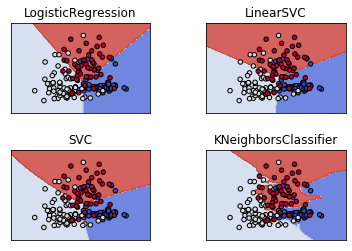

In [0]:
titles = ('LogisticRegression',
          'LinearSVC',
          'SVC',
          'KNeighborsClassifier')  

# Set-up 2x2 grid for plotting.
fig, sub = plt.subplots(2, 2)
plt.subplots_adjust(wspace=0.4, hspace=0.4)

X0, X1 = X[:, 0], X[:, 1]
xx, yy = make_meshgrid(X0, X1)

for clf, title, ax in zip(models, titles, sub.flatten()):
    plot_contours(ax, clf, xx, yy,
                  cmap=plt.cm.coolwarm, alpha=0.8)
    ax.scatter(X0, X1, c=y, cmap=plt.cm.coolwarm, s=20, edgecolors='k')
    ax.set_xlim(xx.min(), xx.max())
    ax.set_ylim(yy.min(), yy.max())
    ax.set_xticks(())
    ax.set_yticks(())
    ax.set_title(title);


## How LogisticRegression makes predictions?

In [0]:
ds = load_breast_cancer()
X = ds.data
y = ds.target

In [0]:
lr = LogisticRegression()
lr.fit(X, y)
lr.predict(X)[10], lr.predict(X)[20]

/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/_logistic.py:940: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG)


(0, 1)

In [0]:
# raw model output
print('lr.coef_ shape', lr.coef_.shape)
print('X[10] shaoe', X[10].shape)
print('Raw output', lr.coef_ @ X[10] + lr.intercept_)
print('since the raw output is negative, we predict the Negative class')

lr.coef_ shape (1, 30)
X[10] shaoe (30,)
Raw output [-6.58983057]
since the raw output is negative, we predict the Negative class


In [0]:
print('Raw output', lr.coef_ @ X[20] + lr.intercept_)
print('since the raw output is positive, we predict the Positive class')

Raw output [5.42097797]
since the raw output is positive, we predict the Positive class


## Minimizing a loss 

Optimize:

\begin{equation}
\min x_1x_4 (x_1+x_3+x_3)+x_3
\end{equation}
\begin{equation}
s.t. x_1x_2x_3x_4>=25
\end{equation}
\begin{equation}
x_1^2+x_2^2+x_3^2+x_4^2=40
\end{equation}
\begin{equation}
1<=x_1,x_2,x_3,x_4<=5
\end{equation}
\begin{equation}
x_0=(1,5,5,1)
\end{equation}

In [0]:
def objective(x):
  x1, x2, x3, x4 = x
  return x1 * x4 * (x1 + x2 +x3) + x3

def constraint1(x):
  x1, x2, x3, x4 = x
  return x1 * x2 * x3 * x4 - 25

def constraint2(x):
  x1, x2, x3, x4 = x
  return 40 - x1**2 - x2**2 - x3**2 - x4**2


In [0]:
x0= [1, 5, 5, 1]
print(objective(x0))

16


In [0]:
b = (1.0, 5.0)
bnds = (b,b,b,b)
con1 = {'type': 'ineq', 'fun': constraint1}
con2 = {'type': 'eq', 'fun': constraint2}
cons = [con1, con2]

In [0]:
sol = minimize(objective, x0, method='SLSQP', bounds=bnds, constraints=cons)
sol

     fun: 17.01401724563517
     jac: array([14.57227015,  1.37940764,  2.37940764,  9.56415057])
 message: 'Optimization terminated successfully.'
    nfev: 30
     nit: 5
    njev: 5
  status: 0
 success: True
       x: array([1.        , 4.7429961 , 3.82115462, 1.37940765])

In [0]:
sol.x

array([1.        , 4.7429961 , 3.82115462, 1.37940765])

In [0]:
boston = load_boston()
X = boston.data
y = boston.target

In [0]:
def my_loss(w):
  l = 0
  for i in range(y.size):
    y_i_true = y[i]
    y_i_pred = w @ X[i]
    l = l + (y_i_true - y_i_pred) ** 2
  return l

In [0]:
w_fit = minimize(my_loss, X[0]).x
w_fit

array([-9.28968320e-02,  4.87152411e-02, -4.05738481e-03,  2.85398463e+00,
       -2.86830574e+00,  5.92815252e+00, -7.26948711e-03, -9.68512138e-01,
        1.71156671e-01, -9.39666264e-03, -3.92188278e-01,  1.49054651e-02,
       -4.16304241e-01])

In [0]:
lr = LinearRegression(fit_intercept=False)
lr.fit(X, y)
lr.coef_

array([-9.28965170e-02,  4.87149552e-02, -4.05997958e-03,  2.85399882e+00,
       -2.86843637e+00,  5.92814778e+00, -7.26933458e-03, -9.68514157e-01,
        1.71151128e-01, -9.39621540e-03, -3.92190926e-01,  1.49056102e-02,
       -4.16304471e-01])

## Comparing the logistic and hinge losses

In [0]:
def log_loss(raw_model_output):
  return np.log(1 + np.exp(-raw_model_output))

In [0]:
def hinge_loss(raw_model_output):
  return np.maximum(0, 1 - raw_model_output)

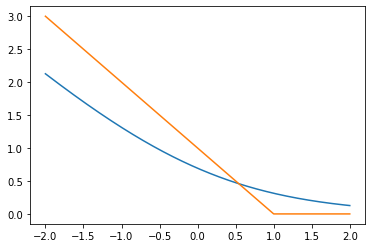

In [0]:
grid = np.linspace(-2, 2, 1000)
plt.plot(grid, log_loss(grid), label='logistic');
plt.plot(grid, hinge_loss(grid), label='hinge');

## Implementing logistic regression

In [0]:
ds = load_breast_cancer()
X = ds.data
y = np.where(ds.target == 0, -1, ds.target)

In [0]:
def my_loss(w):
  l = 0
  for i in range(y.size):
    raw_model_output = w @ X[i]
    l += log_loss(raw_model_output * y[i])
  return l

w_fit = minimize(my_loss, X[0]).x
print(w_fit)

lr = LogisticRegression(fit_intercept=False, C=1000000)
lr.fit(X, y)
print(lr.coef_)

[1.799e+01 1.038e+01 1.228e+02 1.001e+03 1.184e-01 2.776e-01 3.001e-01
 1.471e-01 2.419e-01 7.871e-02 1.095e+00 9.053e-01 8.589e+00 1.534e+02
 6.399e-03 4.904e-02 5.373e-02 1.587e-02 3.003e-02 6.193e-03 2.538e+01
 1.733e+01 1.846e+02 2.019e+03 1.622e-01 6.656e-01 7.119e-01 2.654e-01
 4.601e-01 1.189e-01]
[[ 1.0660862   0.50001866  0.26312059 -0.01646808 -0.04026022 -0.18847567
  -0.26373564 -0.11119512 -0.05574705 -0.0111655   0.04664792  0.42558937
   0.17422577 -0.13293594 -0.00362103 -0.04034038 -0.05625094 -0.01444271
  -0.0134644  -0.00375437  1.13345877 -0.57228181 -0.24533118 -0.01458381
  -0.07286688 -0.58662035 -0.73014074 -0.21369178 -0.17629518 -0.05654333]]


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:2: RuntimeWarning: overflow encountered in exp
  
/usr/local/lib/python3.6/dist-packages/scipy/optimize/optimize.py:697: RuntimeWarning: invalid value encountered in double_scalars
  df = (f(*((xk + d,) + args)) - f0) / d[k]
/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/_logistic.py:940: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG)


In [0]:
X, y = fetch_openml('mnist_784', version=1, return_X_y=True)
random_state = check_random_state(0)
permutation = random_state.permutation(X.shape[0])
X = X[permutation]
y = y[permutation]
X = X.reshape((X.shape[0], -1))
X.shape, y.shape

((70000, 784), (70000,))

In [0]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=10000)
scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)

/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/_logistic.py:940: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG)
/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/_logistic.py:940: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression


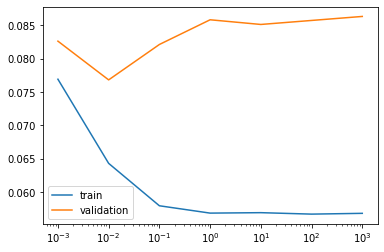

In [0]:
train_errs = list()
valid_errs = list()
C_values = [0.001, 0.01, 0.1, 1, 10, 100, 1000]
for C_value in C_values:
  lr = LogisticRegression(C=C_value)
  lr.fit(X_train, y_train)
  train_errs.append(1.0 - lr.score(X_train, y_train))
  valid_errs.append(1.0 - lr.score(X_test, y_test))

plt.semilogx(C_values, train_errs, C_values, valid_errs)
plt.legend(('train', 'validation'));

In [0]:
# # Train and validaton errors initialized as empty list
# train_errs = list()
# valid_errs = list()

# # Loop over values of C_value
# for C_value in [0.001, 0.01, 0.1, 1, 10, 100, 1000]:
#     # Create LogisticRegression object and fit
#     lr = ____
#     lr.fit(____)
    
#     # Evaluate error rates and append to lists
#     train_errs.append( 1.0 - lr.score(____) )
#     valid_errs.append( 1.0 - lr.score(____) )
    
# # Plot results
# plt.semilogx(C_values, train_errs, C_values, valid_errs)
# plt.legend(("train", "validation"))
# plt.show()

## Logistic regression and feature

In [0]:
from spacy.lang.en.stop_words import STOP_WORDS
movies = fetch_movie_sentiment()
data, labels, target_names = (movies.data, movies.target, movies.target_names)
X_train, X_test, y_train, y_test = train_test_split(data, labels, test_size=0.3, 
                                                    random_state=42)
y_train = np.array(y_train)
y_test = np.array(y_test)
vectorizer = CountVectorizer(min_df=1)
vectorizer.fit(X_train)

CountVectorizer(analyzer='word', binary=False, decode_error='strict',
                dtype=<class 'numpy.int64'>, encoding='utf-8', input='content',
                lowercase=True, max_df=1.0, max_features=None, min_df=1,
                ngram_range=(1, 1), preprocessor=None, stop_words=None,
                strip_accents=None, token_pattern='(?u)\\b\\w\\w+\\b',
                tokenizer=None, vocabulary=None)

In [0]:
lr = LogisticRegression(penalty='l2')
searcher = GridSearchCV(lr, {'C':[0.001, 0.01, 0.1, 1, 10]}, cv=3)
searcher.fit(vectorizer.transform(X_train), y_train)
print('Best CV params', searcher.best_params_)
best_lr = searcher.best_estimator_
coefs = best_lr.coef_
print('Total number of features:', coefs.size)
print('Number of selected features:', np.count_nonzero(coefs))

/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/_logistic.py:940: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG)
/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/_logistic.py:940: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression


Best CV params {'C': 1}
Total number of features: 14978
Number of selected features: 14978


/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/_logistic.py:940: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG)


In [0]:
best_lr.coef_

array([[-0.07044221, -0.13594933, -0.18873476, ..., -0.12842599,
        -0.0437782 , -0.54910657]])

## Regularization and probabilities

In [0]:
X = np.array([[ 1.78862847,  0.43650985],
     [ 0.09649747, -1.8634927 ],
     [-0.2773882 , -0.35475898],
     [-3.08274148,  2.37299932],
     [-3.04381817,  2.52278197],
     [-1.31386475,  0.88462238],
     [-2.11868196,  4.70957306],
     [-2.94996636,  2.59532259],
     [-3.54535995,  1.45352268],
     [ 0.98236743, -1.10106763],
     [-1.18504653, -0.2056499 ],
     [-1.51385164,  3.23671627],
     [-4.02378514,  2.2870068 ],
     [ 0.62524497, -0.16051336],
     [-3.76883635,  2.76996928],
     [ 0.74505627,  1.97611078],
     [-1.24412333, -0.62641691],
     [-0.80376609, -2.41908317],
     [-0.92379202, -1.02387576],
     [ 1.12397796, -0.13191423]])
y = np.array([-1, -1, -1,  1,  1, -1,  1,  1,  1, -1, -1,  1,  1, -1,  1, -1, -1, 
     -1, -1, -1])


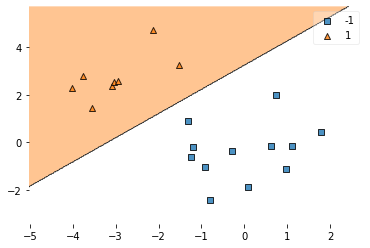

In [0]:
lr = LogisticRegression(C=1)
lr.fit(X, y)
plot_decision_regions(X, y, clf=lr);

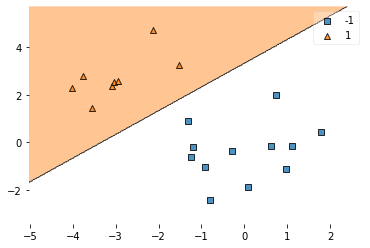

In [0]:
lr = LogisticRegression(C=0.1)
lr.fit(X, y)
plot_decision_regions(X, y, clf=lr);

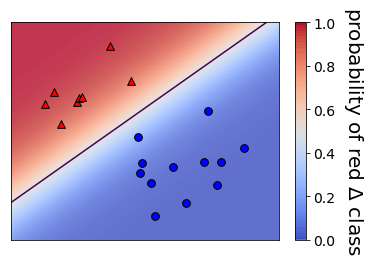

In [0]:
lr = LogisticRegression(C=1)
lr.fit(X, y)
plot_classifier(X, y, lr, proba=True);

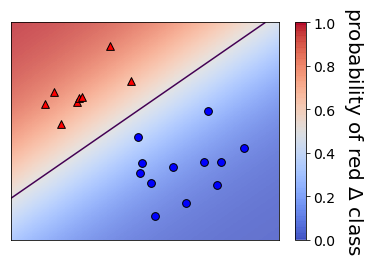

In [0]:
lr = LogisticRegression(C=0.1)
lr.fit(X, y)
plot_classifier(X, y, lr, proba=True);

## Least and Most confident predictions

In [0]:
X, y = fetch_openml('mnist_784', version=1, return_X_y=True)
random_state = check_random_state(0)
permutation = random_state.permutation(X.shape[0])
X = X[permutation]
y = y[permutation].astype('int')
X = X.reshape((X.shape[0], -1))
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=10000)
scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)

In [0]:
lr = LogisticRegression()
lr.fit(X, y)
# proba_inds = np.argsort(np)

/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/_logistic.py:940: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG)


LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
                   intercept_scaling=1, l1_ratio=None, max_iter=100,
                   multi_class='auto', n_jobs=None, penalty='l2',
                   random_state=None, solver='lbfgs', tol=0.0001, verbose=0,
                   warm_start=False)

In [0]:
proba = lr.predict_proba(X)
z = np.max(proba, axis=1)

In [0]:
z

array([0.98221517, 0.99850338, 0.99790959, ..., 0.99756821, 0.98554044,
       0.99406461])

In [0]:
z.shape

(70000,)

In [0]:
X.shape

(70000, 784)

In [0]:
np.argsort(np.max(proba,axis=1))

array([57753, 11040, 53809, ..., 48742, 51728, 20777])

## Fitting multi-class logistic regression

In [0]:
lr_ovr = LogisticRegression()
lr_ovr.fit(X_train, y_train)

print("OVR training accuracy:", lr_ovr.score(X_train, y_train))
print("OVR test accuracy    :", lr_ovr.score(X_test, y_test))

# Fit softmax classifier
lr_mn = LogisticRegression(multi_class='multinomial', solver='lbfgs')
lr_mn.fit(X_train, y_train)

print("Softmax training accuracy:", lr_mn.score(X_train, y_train))
print("Softmax test accuracy    :", lr_mn.score(X_test, y_test))

/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/_logistic.py:940: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG)


OVR training accuracy: 0.9435833333333333
OVR test accuracy    : 0.915
Softmax training accuracy: 0.9435833333333333
Softmax test accuracy    : 0.915


/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/_logistic.py:940: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG)


In [0]:
# svm_class_1 = SVC()
# svm_class_1.fit(X_train, y_train)
# plot_classifier(X_train, y_train, svm_class_1)

In [0]:
# svm_class_1 = SVC()
# svm_class_1.fit(X_train, y_train==1)
# plot_classifier(X_train, y_train==1, svm_class_1)

## Support Vector Machines

In [0]:
wine = load_wine()
X, y = (wine.data[:,:2], wine.target)

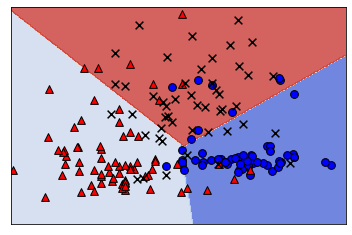

In [0]:
svm = SVC(kernel='linear')
svm.fit(X, y)
plot_classifier(X, y, svm, lims=(11,15,0,6));

In [0]:
print('Number of original exmaples:', len(X))
print('Number of support vectors:', len(svm.support_))

Number of original exmaples: 178
Number of support vectors: 81


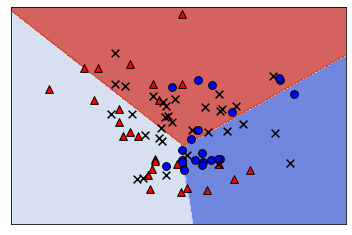

In [0]:
X_small = X[svm.support_]
y_small = y[svm.support_]
svm_small = SVC(kernel='linear')
svm_small.fit(X_small, y_small)
plot_classifier(X_small, y_small, svm_small, lims=(11,15,0,6));

# Kernell SVMs

In [0]:
digits = load_digits()
X = digits.data
y = digits.target == 2
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.5, random_state=43)

In [18]:
svm = SVC()
parameters = {'gamma' : [0.00001, 0.0001, 0.001, 0.01, 0.1]}
searcher = GridSearchCV(svm, parameters, cv=3)
searcher.fit(X_train, y_train)
print('Best CV params', searcher.best_params_)

Best CV params {'gamma': 0.001}


In [19]:
svm = SVC()
parameters =  {'C' : [0.0001, 0.001, 0.1, 0.25, 0.5, 1, 10],
               'gamma' : [0.00001, 0.0001, 0.001, 0.01, 0.1]}
searcher = GridSearchCV(svm, parameters)
searcher.fit(X_train, y_train)
print('Best CV params', searcher.best_params_)
print('Best CV accuracy', searcher.best_score_)

print('Test accuracy of best grid search hypers:', searcher.score(X_test, y_test))

Best CV params {'C': 10, 'gamma': 0.0001}
Best CV accuracy 1.0
Test accuracy of best grid search hypers: 0.9977753058954394


## SGDClassifier

In [21]:
linear_classifier = SGDClassifier(random_state=0)
parameters = {
    'alpha' : [0.00001, 0.0001, 0.001, 0.01, 0.1, 1],
    'loss' : ['hinge', 'log'],
    'penalty': ['l1', 'l2']
}
searcher = GridSearchCV(linear_classifier, parameters, cv=10)
searcher.fit(X_train, y_train)
print('Best CV params', searcher.best_params_)
print('Best CV accuracy', searcher.best_score_)
print('Test accuracy of best grid search hypers:', searcher.score(X_test, y_test))

Best CV params {'alpha': 0.01, 'loss': 'hinge', 'penalty': 'l2'}
Best CV accuracy 0.9977777777777778
Test accuracy of best grid search hypers: 0.9977753058954394
